Tarea 2 - Gabriel García

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

In [ ]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 32.0 MB/s 


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


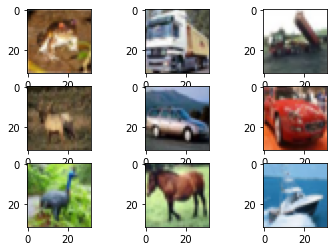

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

nn_model = NN()

In [ ]:
# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    nn_model.to("cuda")

torchsummary.summary(nn_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
            Linear-8                  [-1, 100]         204,900
            Linear-9                   [-1, 10]           1,010
Total params: 303,350
Trainable params: 303,350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 1.16
Estimated Total Size (MB): 1.46
-------------------------------------------

In [ ]:
# Optimizador

nn_optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

# Función de error
nn_loss = torch.nn.CrossEntropyLoss()

# Métrica
nn_accuracy = torchmetrics.Accuracy()

In [ ]:
if torch.cuda.is_available():
  nn_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    nn_optimizer.zero_grad()
    output = nn_model(train_data)
    loss = nn_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    nn_optimizer.step()
    accuracy = nn_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

   # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = nn_model(valid_data)
    epoch_valid_loss += nn_loss(output, valid_target).item()
    epoch_valid_accuracy += nn_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))



Epoch: 1/20 - Train loss 2.301316 - Train Accuracy 0.113317 - Valid Loss 2.297824 - Valid Accuracy 0.115048
Epoch: 2/20 - Train loss 2.223822 - Train Accuracy 0.167044 - Valid Loss 2.166556 - Valid Accuracy 0.200040
Epoch: 3/20 - Train loss 1.994305 - Train Accuracy 0.266347 - Valid Loss 1.942084 - Valid Accuracy 0.268511
Epoch: 4/20 - Train loss 1.888048 - Train Accuracy 0.310212 - Valid Loss 1.825417 - Valid Accuracy 0.322253
Epoch: 5/20 - Train loss 1.730659 - Train Accuracy 0.369514 - Valid Loss 1.682754 - Valid Accuracy 0.382365
Epoch: 6/20 - Train loss 1.582520 - Train Accuracy 0.425107 - Valid Loss 1.534440 - Valid Accuracy 0.446059
Epoch: 7/20 - Train loss 1.472341 - Train Accuracy 0.467284 - Valid Loss 1.636374 - Valid Accuracy 0.389331
Epoch: 8/20 - Train loss 1.392869 - Train Accuracy 0.497779 - Valid Loss 1.584061 - Valid Accuracy 0.421975
Epoch: 9/20 - Train loss 1.325658 - Train Accuracy 0.524676 - Valid Loss 1.520847 - Valid Accuracy 0.460987
Epoch: 10/20 - Train loss 1.

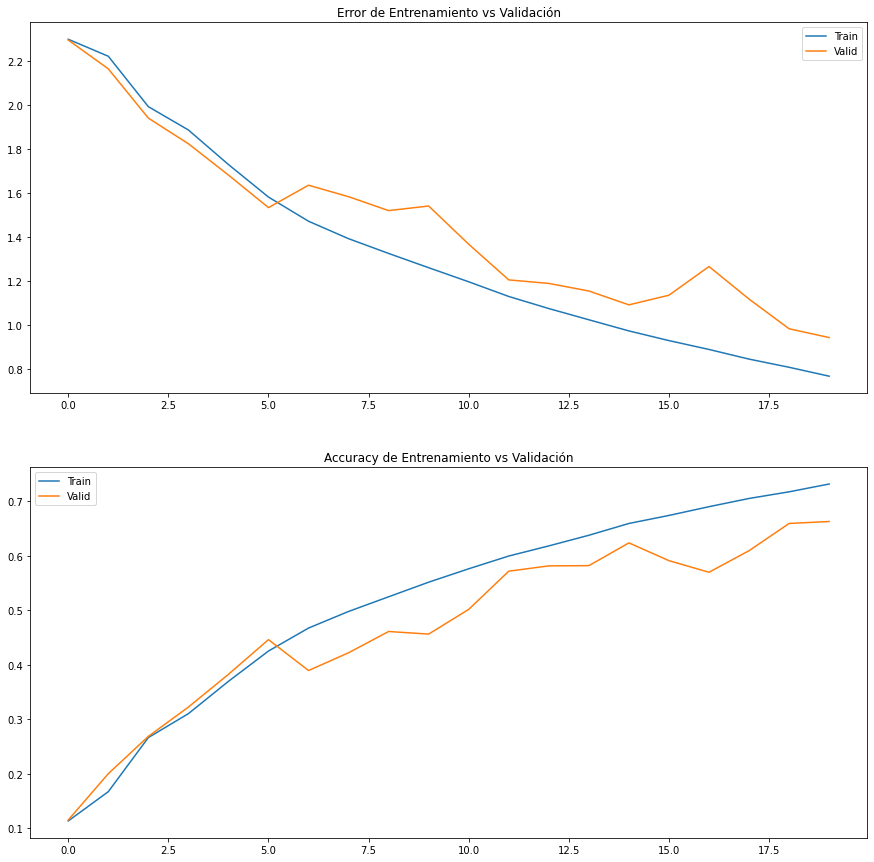

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Observando las graficas se evidencia un sobreentrenamiento debido a que el error se reduce mucho más en el conjunto en entrenamiento en comparación con el error de validación. A su vez, el accuracy es considerablemente mayor en el set de train comparado con el de validación. 

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = nn_model(test_data)
  test_loss += nn_loss(output, test_target).item()
  test_accuracy += nn_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.954606 y una accuracy de 0.668031


In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.RandomHorizontalFlip(p = 0.5),
                    torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                    torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                    torchvision.transforms.ToTensor()
                  ])


aug_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = data_transforms)
aug_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
aug_valid_set_size = 5000

aug_train_set, aug_valid_set = torch.utils.data.random_split(aug_train_set, [len(aug_train_set) - aug_valid_set_size, aug_valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(aug_train_set)))
print("Tamaño del conjunto de validación: {}".format(len(aug_valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [ ]:
aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)
aug_test_loader = torch.utils.data.DataLoader(aug_test_set, batch_size=32, shuffle=True)

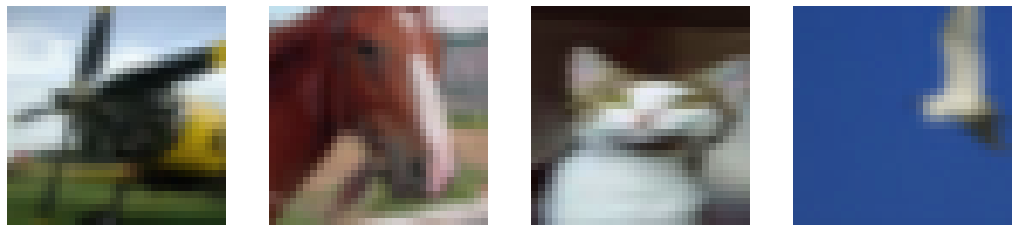

In [ ]:
# Imprimimos algunas imágenes generadas por el data augmentation
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Corremos la misma arquitectura de red neuronal anterior, pero junto con los datos sobre los que realizó las perturbaciones antes definidas. 

In [ ]:
aug_conv_model = NN()

if torch.cuda.is_available():
  aug_conv_model = aug_conv_model.to("cuda")

aug_conv_model_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.001)

aug_conv_model_loss = torch.nn.CrossEntropyLoss()

aug_conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  aug_conv_model_accuracy = aug_conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 40

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_conv_model_optimizer.zero_grad()
    
    aug_output = aug_conv_model(aug_train_data)
    
    aug_loss = aug_conv_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_conv_model_optimizer.step()
    accuracy = aug_conv_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_conv_model(aug_valid_data)
    epoch_valid_loss += aug_conv_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_conv_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/40 - Train loss 1.739953 - Train Accuracy 0.356499 - Valid Loss 1.577923 - Valid Accuracy 0.419785
Epoch: 2/40 - Train loss 1.451953 - Train Accuracy 0.470749 - Valid Loss 1.363691 - Valid Accuracy 0.501990
Epoch: 3/40 - Train loss 1.328770 - Train Accuracy 0.523143 - Valid Loss 1.278815 - Valid Accuracy 0.547174
Epoch: 4/40 - Train loss 1.225184 - Train Accuracy 0.561856 - Valid Loss 1.169081 - Valid Accuracy 0.588376
Epoch: 5/40 - Train loss 1.150416 - Train Accuracy 0.590707 - Valid Loss 1.138112 - Valid Accuracy 0.600318
Epoch: 6/40 - Train loss 1.089379 - Train Accuracy 0.616316 - Valid Loss 1.095565 - Valid Accuracy 0.610868
Epoch: 7/40 - Train loss 1.044656 - Train Accuracy 0.630353 - Valid Loss 1.087345 - Valid Accuracy 0.618232
Epoch: 8/40 - Train loss 1.007679 - Train Accuracy 0.645145 - Valid Loss 1.046169 - Valid Accuracy 0.629578
Epoch: 9/40 - Train loss 0.972885 - Train Accuracy 0.655983 - Valid Loss 1.028750 - Valid Accuracy 0.640525
Epoch: 10/40 - Train loss 0.

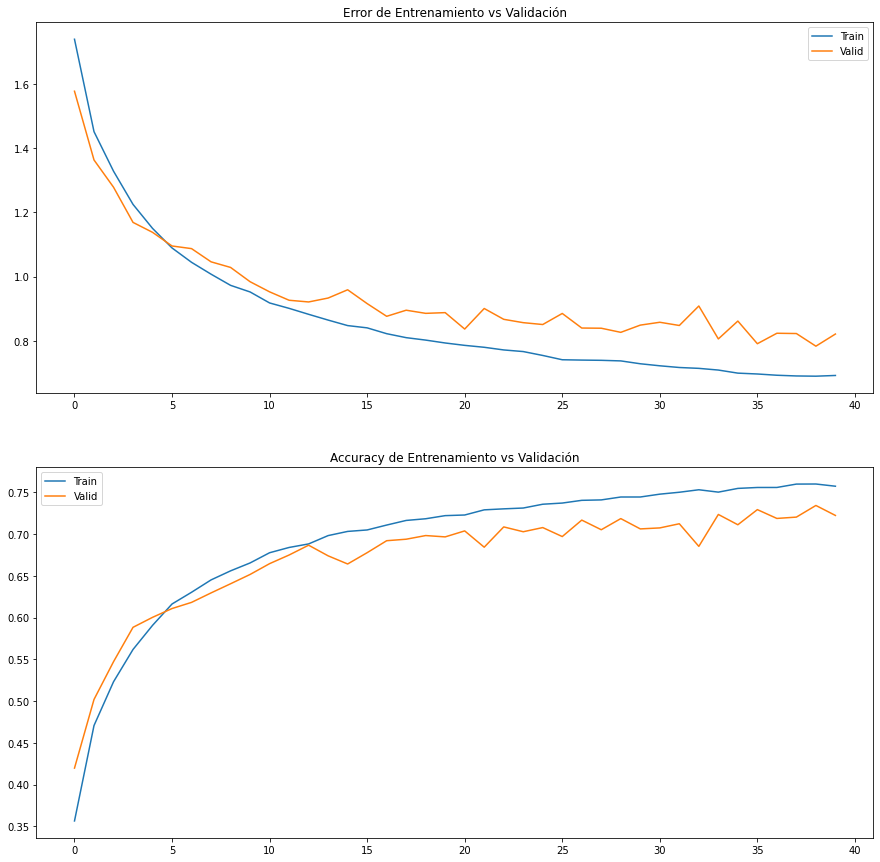

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Al aplicar data augmentation el dataset se vuelve más grande, ya que al aplicar transformaciones sobre los datos estamos generando data sintética nueva, dependiendo de cuántos tipos diferentes de data augmentation utilicemos. El entrenamiento va a tardar en proporción a la cantidad de técnicas empleadas para hacer data augmentation. Lo anterior produce que los resultados tanto en train como en validación sean más estables pero que la mejora producida tras cada época sea más lenta. 